### Instructions

1) Please push the .ipynb and .pdf to Github Classroom prior to the deadline, .py file is optional (not needed).<br>
2) Please include your Name and UNI below.

### Name: Jessica Li
### UNI: yl5542

##Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint
pp = pprint.PrettyPrinter(indent=4)
import warnings
warnings.filterwarnings("ignore")
import tensorflow
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

2023-11-21 17:57:03.221273: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Part 1: Neural Network from the scratch
For this part, you are not allowed to use any library other than numpy.

In this part, you will will implement the forward pass and backward pass (i.e. the derivates of each
parameter wrt to the loss) with the network image uploaded.

The weight matrix for the hidden layer is W1 and has bias b1.

The weight matrix for the ouput layer is W2 and has bias b2.

Activatation function is sigmoid for both hidden and output layer

Loss function is the MSE loss

Refer to the below dictionary for dimensions for each matrix


In [2]:
np.random.seed(0) # don't change this
weights = {
'W1': np.random.randn(3, 2),
'b1': np.zeros(3),
'W2': np.random.randn(3),
'b2': 0,
}
X = np.random.rand(1000,2)
Y = np.random.randint(low=0, high=2, size=(1000,))

In [3]:
#Sigmoid Function
def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [4]:
#Implement the forward pass
def forward_propagation(X, weights):
    # Z1 -> output of the hidden layer before applying activation
    # H -> output of the  hidden layer after applying activation
    # Z2 -> output of the final layer before applying activation
    # Y -> output of the final layer after applying activation

    Z1 = np.dot(X, weights['W1'].T)  + weights['b1']
    H = sigmoid(Z1)

    Z2 = np.dot(H, weights['W2'].T) + weights['b2']

    Y = sigmoid(Z2)

    return Y, Z2, H, Z1

In [5]:
# Implement the backward pass
# Y_T are the ground truth labels
def back_propagation(X, Y_T, weights):
    N_points = X.shape[0]

    # forward propagation
    Y, Z2, H, Z1 = forward_propagation(X, weights)
    L = (1/(2*N_points)) * np.sum(np.square(Y - Y_T))

    # back propagation
    dLdY = 1/N_points * (Y - Y_T)
    dLdZ2 = np.multiply(dLdY, (sigmoid(Z2)*(1-sigmoid(Z2))))
    dLdW2 = np.dot(H.T, dLdZ2)

    ones = np.ones((1000))
    dLdb2 = np.dot(ones.T, dLdZ2)                        
    dLdH = np.dot(dLdZ2.reshape(-1,1), weights['W2'].reshape(-1,1).T)
    dLdZ1 = np.multiply(dLdH, (sigmoid(Z1)*(1-sigmoid(Z1))))
    dLdW1 = np.dot(X.T, dLdZ1)
    dLdb1 = np.dot(ones.T, dLdZ1)  

    gradients = {
        'W1': dLdW1,
        'b1': dLdb1,
        'W2': dLdW2,
        'b2': dLdb2,
    }

    return gradients, L

In [6]:
gradients, L = back_propagation(X, Y, weights)
print(L)

0.1332476222330792


In [7]:
pp.pprint(gradients)

{   'W1': array([[ 0.00244596, -0.00030765, -0.00034768],
       [ 0.00262019, -0.00024188, -0.000372  ]]),
    'W2': array([0.02216011, 0.02433097, 0.01797174]),
    'b1': array([ 0.00492577, -0.00058023, -0.00065977]),
    'b2': 0.029249230265318685}


Your answers should be close to L = 0.133 and 'b1': array([ 0.00492, -0.000581, -0.00066]). You will be graded based on your implementation and outputs for L, W1, W2 b1, and b2

# Part 2: Neural network to classify images: CIFAR-10

CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). The train/test split is 50k/10k.

In [8]:
from tensorflow.keras.datasets import cifar10
(x_dev, y_dev), (x_test, y_test) = cifar10.load_data()

LABELS = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

### 2.1 Plot 50 samples from each class/label from train set on a 10*5 subplot

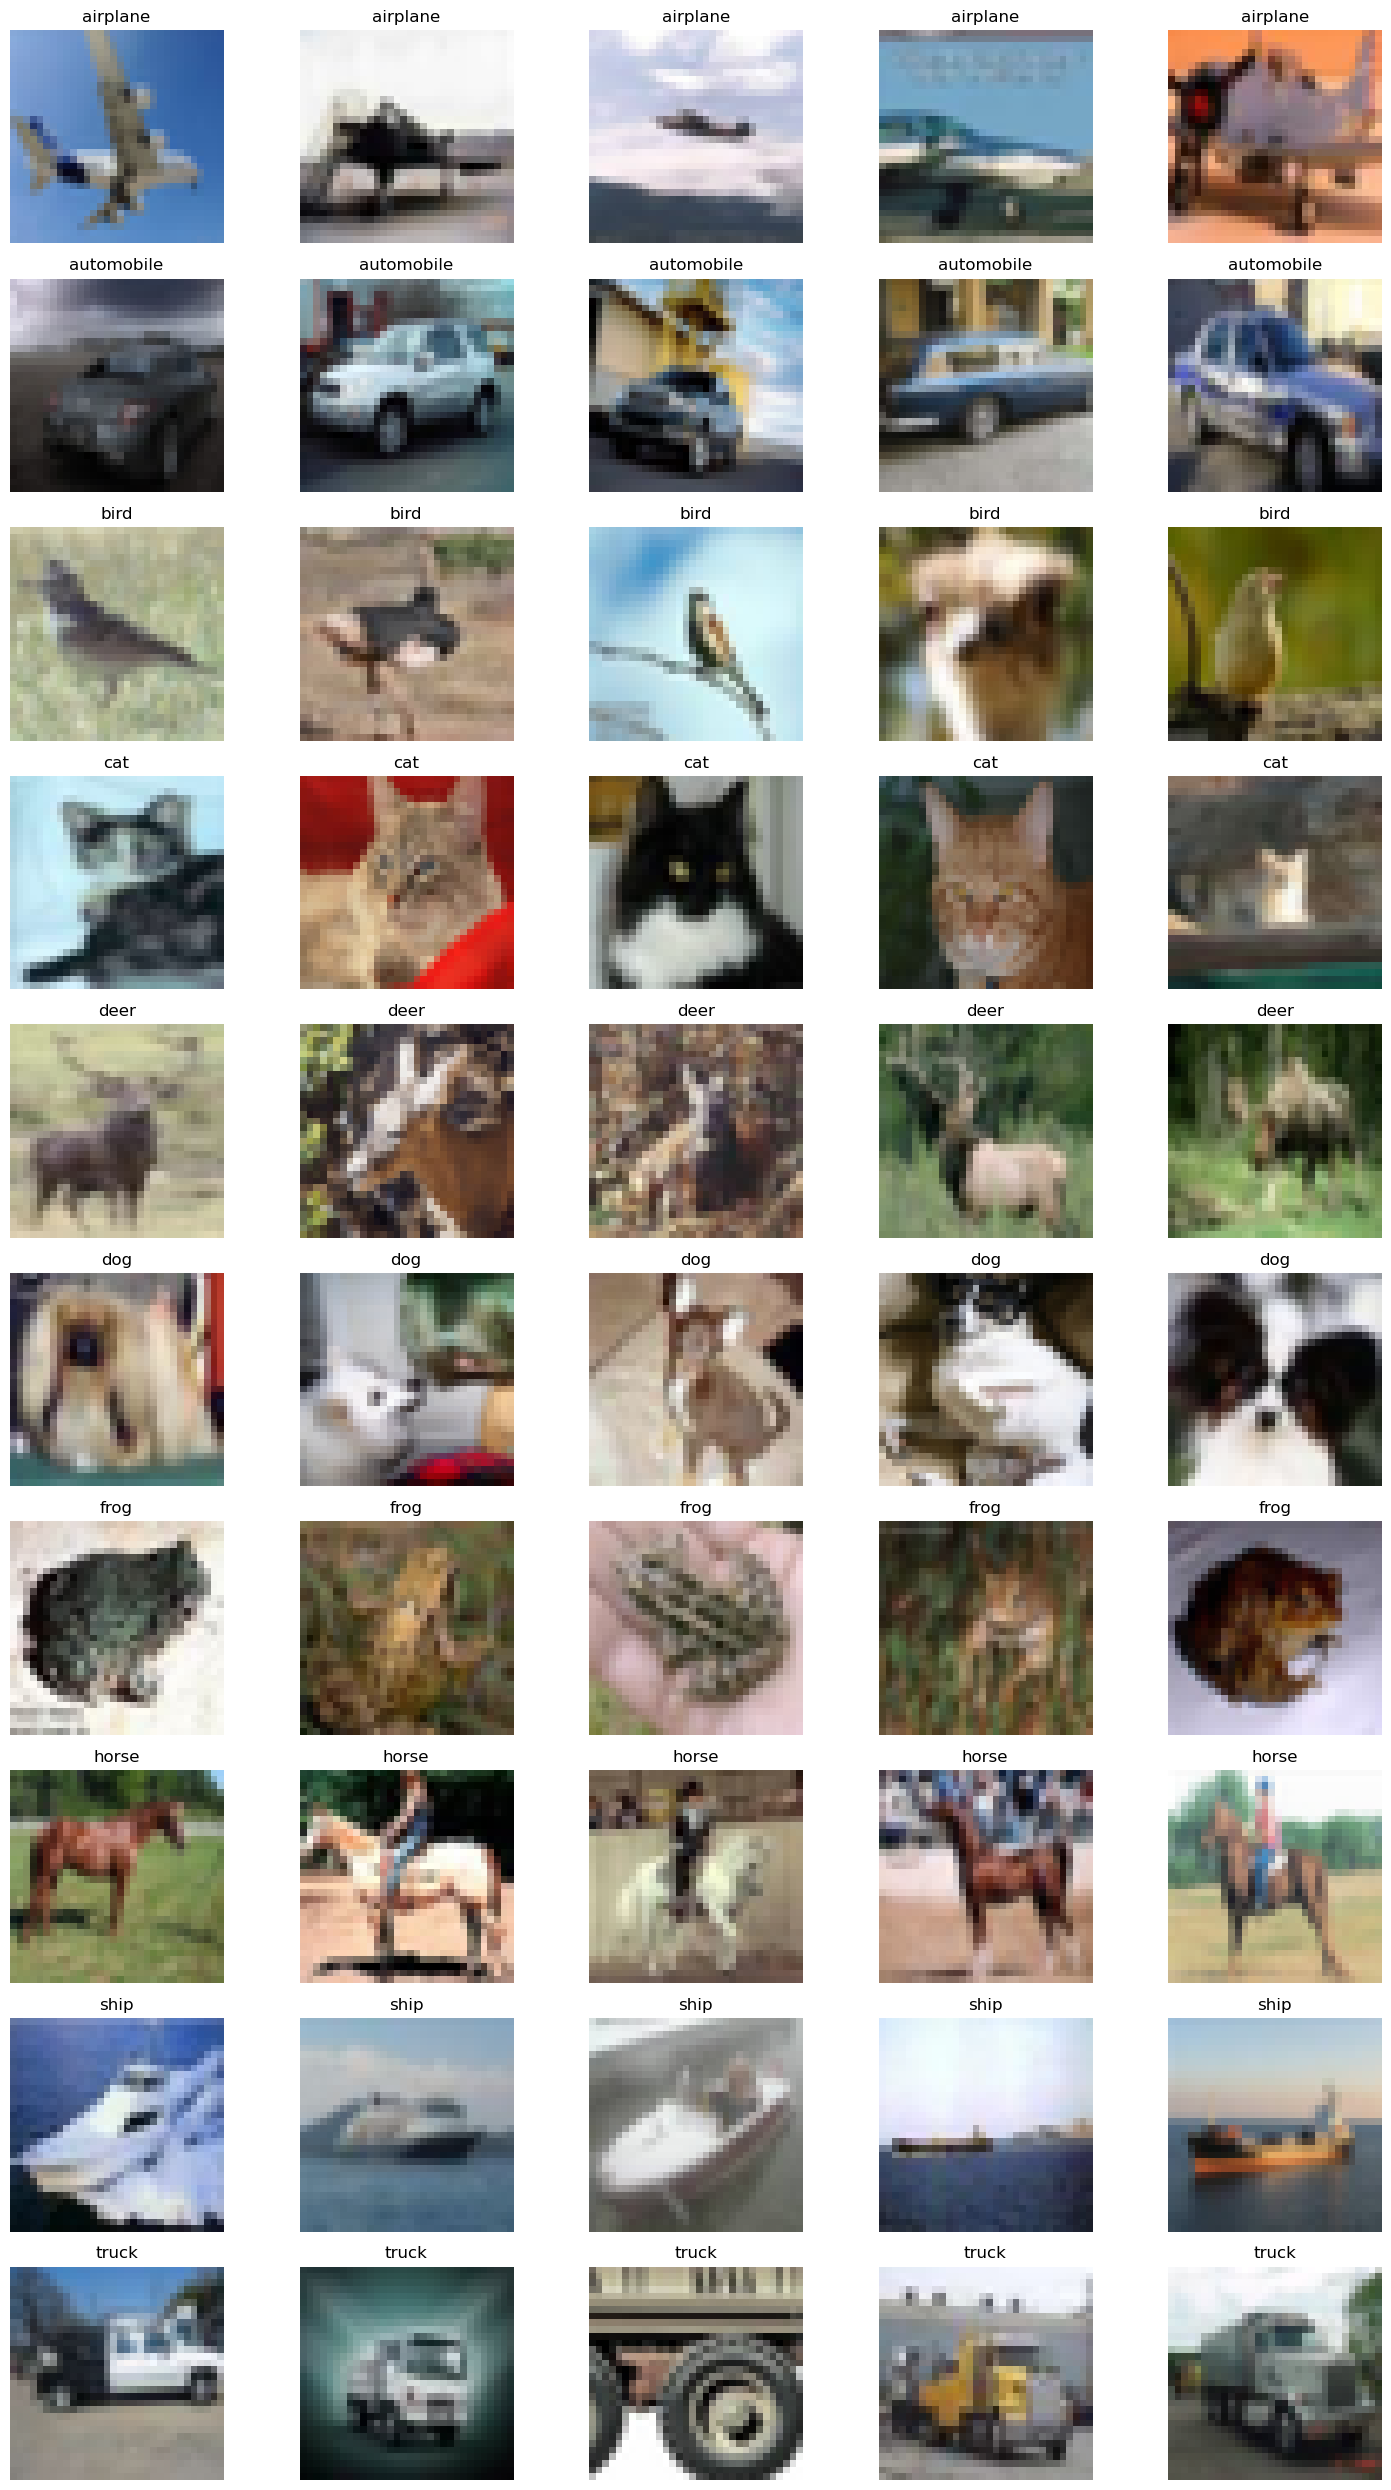

In [9]:
# Create a 10x5 subplot
fig, axes = plt.subplots(10, 5, figsize=(15, 25))

# Loop through each subplot
for i in range(10):
    label_index = i  
    class_indices = np.where(np.array(y_dev.flatten()) == label_index)[0]
    random_indices = np.random.choice(class_indices, 5, replace=False)

    # Loop through each random index
    for j, index in enumerate(random_indices):
        axes[i, j].imshow(x_dev[index])
        axes[i, j].axis('off')
        axes[i, j].set_title(LABELS[label_index])


plt.tight_layout()
plt.show()

### 2.2 Preparing the dataset for NN

1) Print the shapes -  𝑥𝑑𝑒𝑣, 𝑦𝑑𝑒𝑣, 𝑥𝑡𝑒𝑠𝑡, 𝑦𝑡𝑒𝑠𝑡

2) Flatten the images into one-dimensional vectors and again print the shapes of  𝑥𝑑𝑒𝑣, 𝑥𝑡𝑒𝑠𝑡

3) Standardize the development and test sets.

4) Train-test split your development set into train and validation sets (8:2 ratio).

In [10]:
#printing the shapes
print('xdev shape: ', x_dev.shape)
print('ydev shape: ', y_dev.shape)
print('xtest shape: ', x_test.shape)
print('ytest shape: ', y_test.shape)

xdev shape:  (50000, 32, 32, 3)
ydev shape:  (50000, 1)
xtest shape:  (10000, 32, 32, 3)
ytest shape:  (10000, 1)


In [11]:
#Faltten the images
x_dev_flat = x_dev.reshape(x_dev.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)
print('falttened xdev shape: ', x_dev_flat.shape)
print('falttened xtest shape: ', x_test_flat.shape)

falttened xdev shape:  (50000, 3072)
falttened xtest shape:  (10000, 3072)


In [12]:
#Standarize dev and test
x_dev_flat = x_dev_flat.astype('float32')
x_test_flat = x_test_flat.astype('float32')
x_dev = x_dev.astype('float32')
x_test = x_test.astype('float32')
x_dev_flat /= 255
x_test_flat /= 255
num_classes = 10
y_dev = to_categorical(y_dev, num_classes)
y_test = to_categorical(y_test, num_classes)

In [13]:
# 80-20 train, validation split
x_train, x_val, y_train, y_val = train_test_split(x_dev_flat, y_dev, test_size=0.2, random_state=42)

### 2.3 Build the feed forward network with the below specifications

First layer size = 128

hidden layer size = 64

last layer size = Figure this out from the data!

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation

#Your code here
model = Sequential([
    Dense(128, input_shape=(3072,), activation='relu'),
    Dense(64,activation='relu'),
    Dense(num_classes,activation='softmax')
    ])

model.compile()


### 2.4 Print out the model summary. Mention the number of parameters for each layer.

In [15]:
#Your code here
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               393344    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 


 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 402250 (1.53 MB)
Trainable params: 402250 (1.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 2.5 Do you think the number of parameters is dependent on the image height and width?

Yes, I believe the size of the input data, such as image dimensions in terms of height and width, plays a role in determining the number of parameters. For example, the number of parameter for the first layer 393344 is given by 3073 x 128, were 3073 is given by the size of the image and 128 is the size of the first layer. Going on, the number of parameter at dense_1 layer 8256 is given by (128+1) x 64, where the +1 is for the bias term. And this formula applies at later layers too. Therefore we can see that the number of parameters is dependent on the input size and hence the image height and width, as the size of input is determined by the imgae size. 

**Printing out your model's output on first train sample. This will confirm if your dimensions are correctly set up. The sum of this output equal to 1 upto two decimal places?**

In [17]:
#modify name of X_train based on your requirement

output = model.predict(x_train[0].reshape(1,-1))

print("Output: {:.2f}".format(sum(output[0])))

1/1 [==============================] - 3s 3s/step
Output: 1.00


### 2.6 Using the right metric and  the right loss function, with Adam as the optimizer, train your model for 20 epochs.

In [18]:
#Your code here
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [19]:
Model=model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
1250/1250 [==============================] - 18s 14ms/step - loss: 1.9024 - accuracy: 0.3128 - val_loss: 1.7952 - val_accuracy: 0.3583
Epoch 2/20
1250/1250 [==============================] - 12s 9ms/step - loss: 1.7259 - accuracy: 0.3817 - val_loss: 1.7219 - val_accuracy: 0.3880
Epoch 3/20
1250/1250 [==============================] - 18s 14ms/step - loss: 1.6477 - accuracy: 0.4138 - val_loss: 1.6345 - val_accuracy: 0.4136
Epoch 4/20
1250/1250 [==============================] - 16s 13ms/step - loss: 1.5987 - accuracy: 0.4333 - val_loss: 1.5919 - val_accuracy: 0.4267
Epoch 5/20
1250/1250 [==============================] - 9s 7ms/step - loss: 1.5638 - accuracy: 0.4441 - val_loss: 1.5934 - val_accuracy: 0.4206
Epoch 6/20
1250/1250 [==============================] - 10s 8ms/step - loss: 1.5352 - accuracy: 0.4512 - val_loss: 1.5542 - val_accuracy: 0.4546
Epoch 7/20
1250/1250 [==============================] - 9s 7ms/step - loss: 1.5088 - accuracy: 0.4631 - val_loss: 1.5346 - val_a

### 2.7 Plot the training curves described below

### 2.7.1 Display the train vs validation loss over each epoch


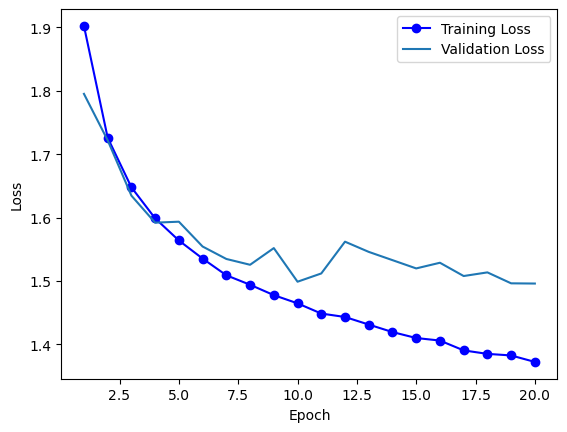

In [20]:
#Your code here

hist = pd.DataFrame(Model.history)
fig, ax = plt.subplots()
ax.plot(range(1, len(hist) + 1), hist["loss"], 'bo-', label="Training Loss")
ax.plot(range(1, len(hist) + 1), hist["val_loss"], label="Validation Loss")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend()
plt.show()


### 2.7.2 Display the train vs validation accuracy over each epoch

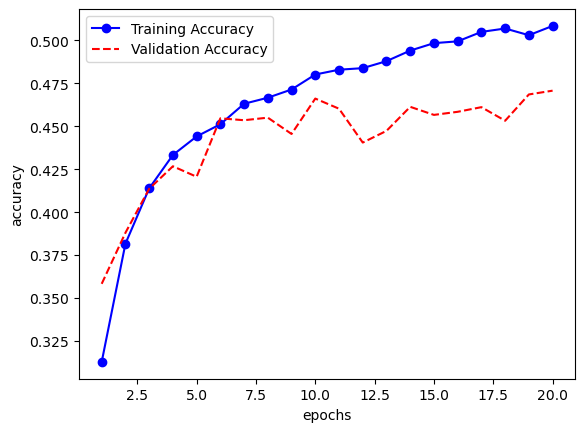

In [21]:
#Your code here
fig, ax = plt.subplots()
ax.plot(range(1, len(hist) + 1), hist["accuracy"], 'bo-', label="Training Accuracy")
ax.plot(range(1, len(hist) + 1), hist["val_accuracy"],'r--', label="Validation Accuracy")
ax.set_ylabel("accuracy")
ax.set_xlabel("epochs")
ax.legend()
plt.show()

### 2.8 Finally, report the metric chosen on test set

In [22]:
#Your code here
score = model.evaluate(x_test_flat, y_test, verbose = 0)
print("Test Loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))

Test Loss: 1.490
Test Accuracy: 0.473


### 2.9 Plot the first 50 samples of test dataset on a 10*5 subplot and this time label the images with both the ground truth (GT) and predicted class (P). (Make sure you predict the class with the improved model)

313/313 [==============================] - 2s 5ms/step


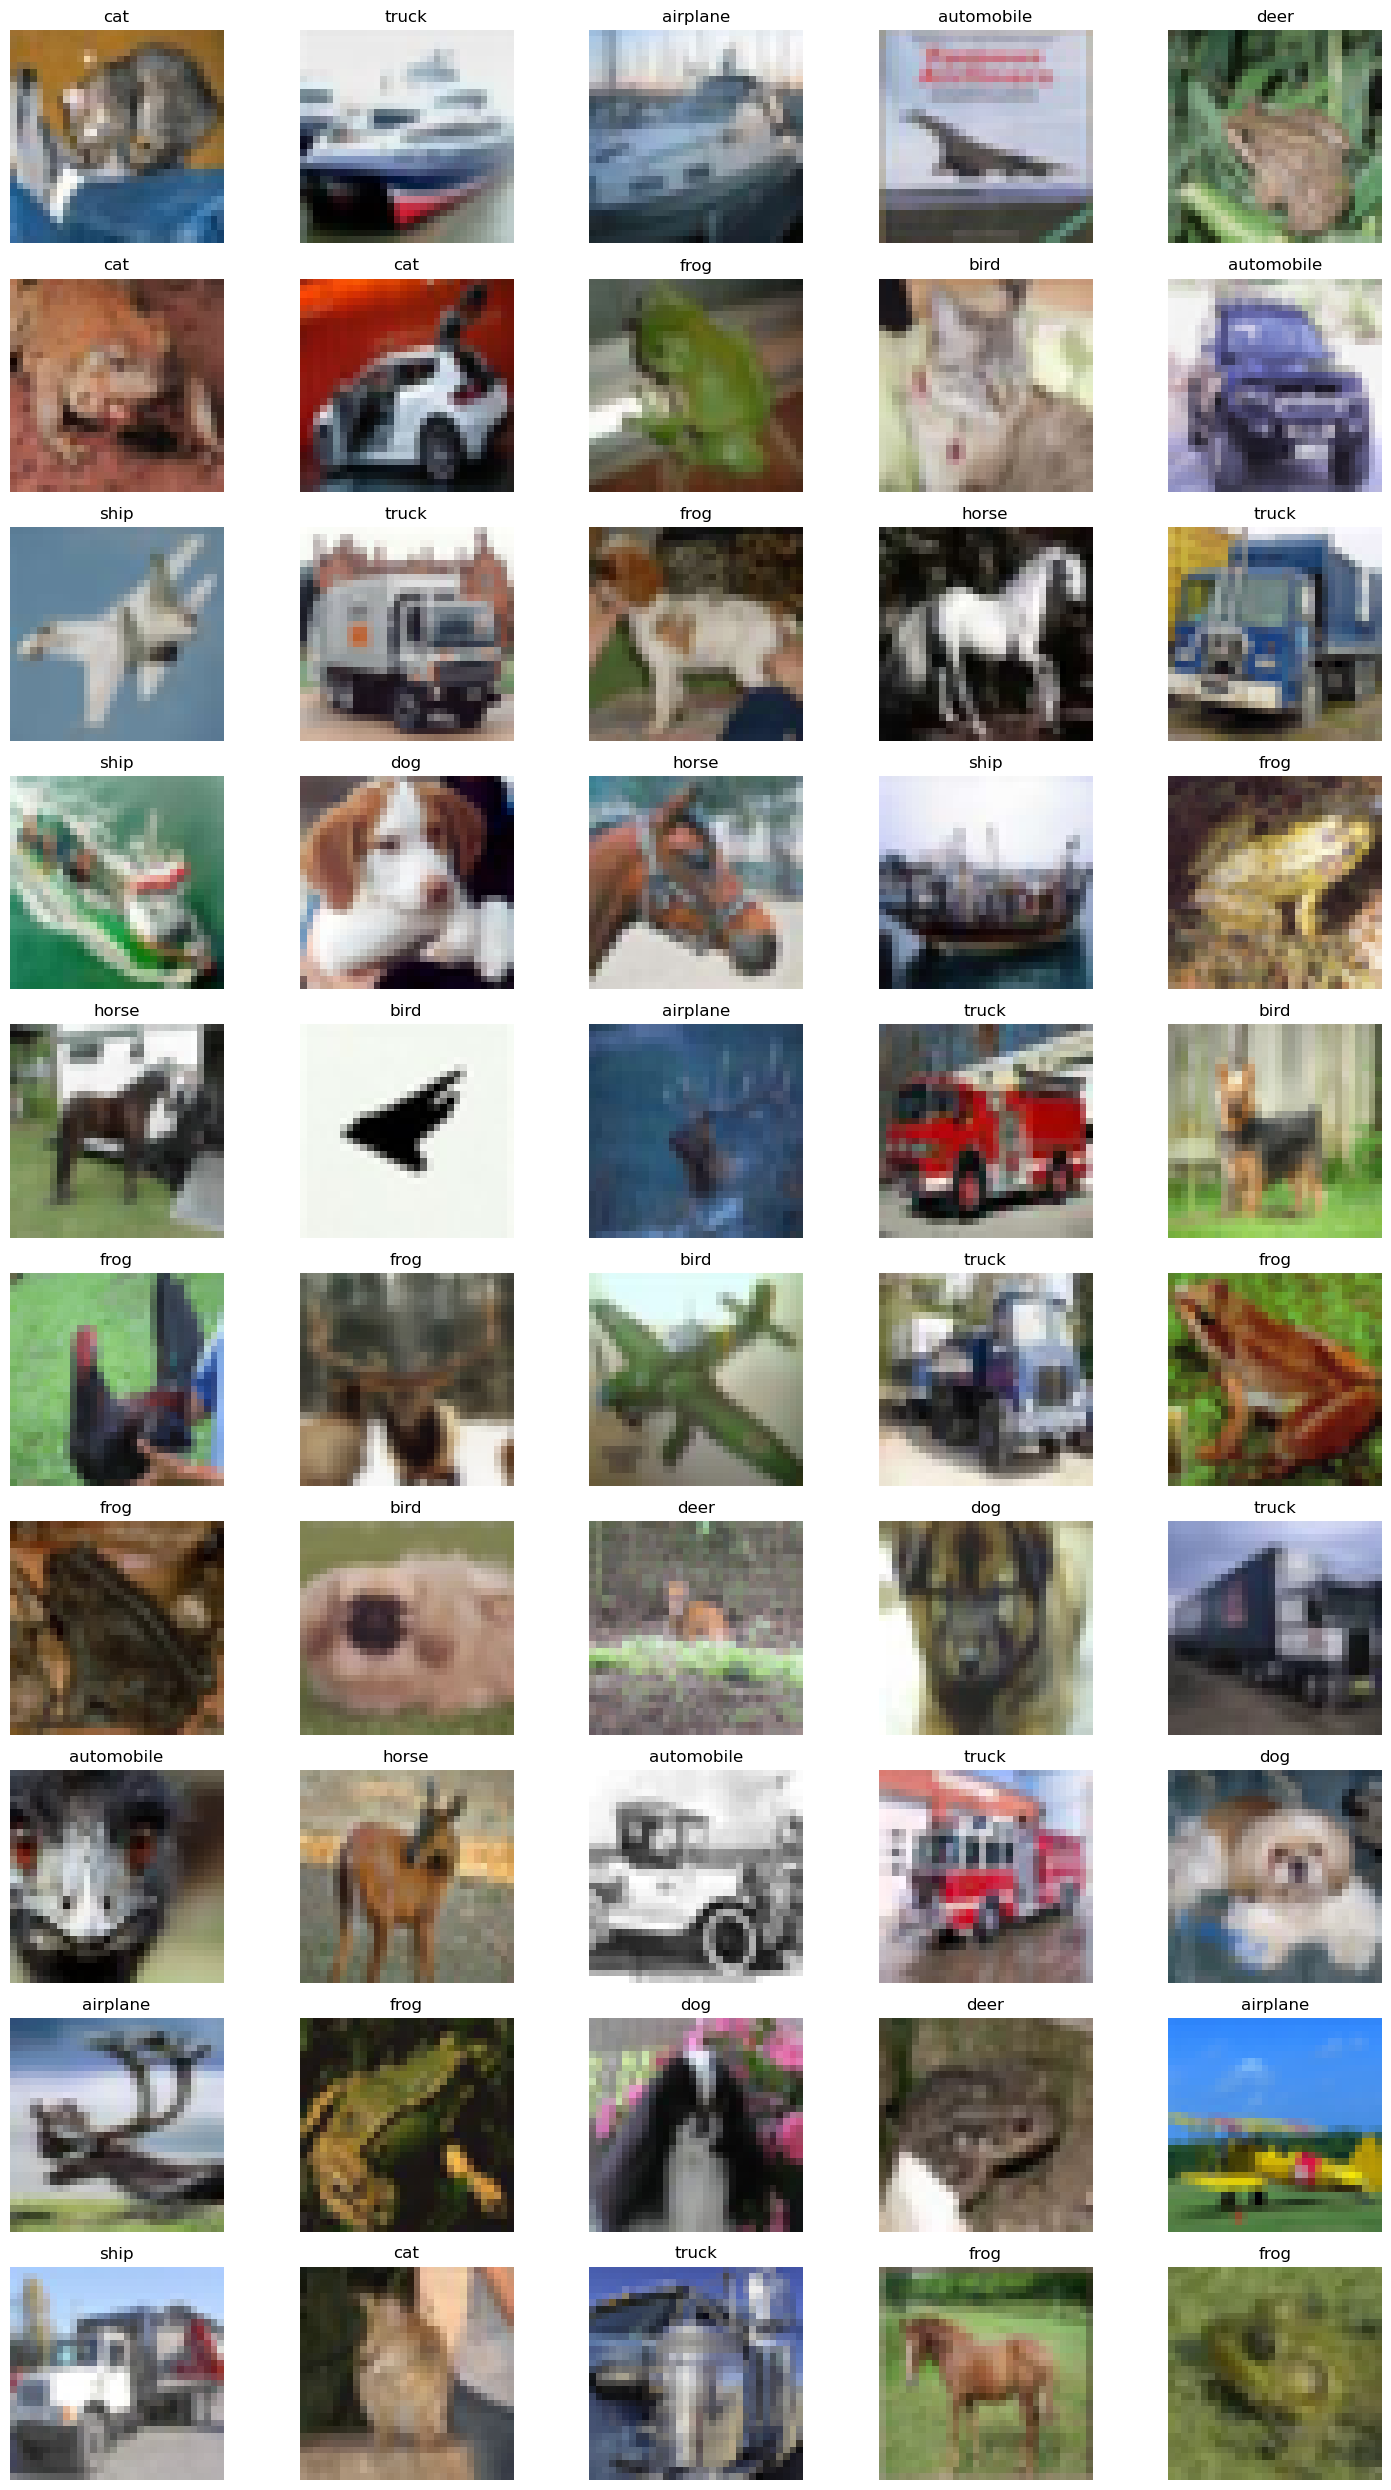

In [28]:
#Your code here

predictions = model.predict(x_test_flat)
predicted_labels = np.argmax(predictions, axis=1)

fig, axes = plt.subplots(10, 5, figsize=(15, 25))

for i in range(50):
    ax = axes[i // 5, i % 5]  
    ax.imshow(x_test_flat[i].reshape((32, 32, 3))) 
    ax.axis('off')
    true_class = y_test[i, 0] 
    pred_class = predicted_labels[i]
    ax.set_title(LABELS[pred_class])


plt.tight_layout()
plt.show()